# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science 

## Lab 6: Principal Components Analysis (PCA)

**Harvard University**<br/>
**Fall 2021**<br/>
**Instructors**: Pavlos Protopapas and Natesh Pillai<br/>
**Lab Team**: Marios Mattheakis, Hayden Joy, Chris Gumb, and Eleni Kaxiras<br/>
**Authors**: Marios Mattheakis, Hayden Joy 
<hr style='height:2px'>

In [1]:
# Data and stats packages
import numpy as np
import pandas as pd

# Visualization packages
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# NEW PACKAGES
from sklearn.decomposition import PCA
from time import time


# Other packages
pd.set_option('display.max_columns', 50)
import warnings
warnings.filterwarnings("ignore")

# What is Principal Components Analysis (PCA)?

## A Framework For Dimensionality Reduction

Consider that the data are described by a Linear Regression Model:
$$
Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_p X_p + \epsilon,
$$
where  $p$ is very large, i.e. **high dimensionality**.


**PCA for dimensional reduction:**

Considering a new system of coordinates, namely a new set of predictors, denoted by
 $Z_1$, $Z_2$,$\dots$, $Z_m$, where $m \leq p$ and where each $Z_i$ is a linear combination of the original $p$ predictors, $X_1, \dots~ X_p$, thus:

$$
Z_i = \sum_{j=1}^{p} c_{ij} X_i
$$

for some fixed coefficients $c_{ij}$  (PCA will determine them).  For  example:
$$
Z_1 = 3.3 X_1 + 4 X_2 + 0 X_3 + \dots + 1.2 X_p.
$$

Then we can build a linear regression model using the new predictors as follows:
$$
Y = \theta_0 + \theta_1 Z_1 + \theta_2 Z_2 + \dots + \theta_m Z_m + \epsilon
$$

**Notice:** For $m=p$ the number of predictors is the same, hence, we have not lost any information. We just  transform the coordinate systems of the *data-space*. 

**Determine the PCA coefficients $c_{ij}$:**
PCA  identifies a new set of predictors, as linear combinations of the original ones, that captures the *maximum amount* of variance  in the observed data. In other words, PCA determines the $c_{ij}$ such as the data varies most along the new axis $Z_i$, which are called **principal components**. PCA  sorts the axis such as the largest variance goes along $Z_1$, the second largest variance goes to $Z_2$ and so on.

**Comments:**
- The  basic assumption in PCA is that higher variance indicates more importance
- The principal components consist an $m$-dimensional **orthonormal** system of coordinates


<img src="https://github.com/reworkhow/ANS198/blob/main/CaseStudy3/fig/pca.png?raw=1" width="400">

We see that the "best line" is the one where there is maximal variance along the line. Source [here](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues/140579).

<img src="https://github.com/reworkhow/ANS198/blob/main/CaseStudy3/fig/pca.gif?raw=1" width="1000">

In principle, we could explore all the rotations, that is, rotating the original coordinate system under all the angles, and find which rotation yields the maximum variance. However, when the dimensionality (p) is large this is an extremely  time consuming and inefficient technique. In that case we may use PCA which is systematic way to find the best rotation or the best coordinate system. 
PCA is a mathematical method based on linear algebra, for more details and rigorous formulation check the advanced section for PCA.


**Have we reduced the dimensions yet?**
No yet... So far we have defined new predictors that linearly depend on the original predictors. Hence, we still have all the information stored in the data. 

**Reducing the dimensions:** Since the $Z_j$ are sorted with respect how much information the *carry*, the larger the $j$ the less important the $Z_j$. Hence, we can keep just a few of the principal components and drop the rest. For instance, keeping only the first two components $(m=2)$, we obtain two predictors that contain information from all the original $p$ predictors. 

How can we choose the m? PCA takes care of that too.

## Applications of PCA

One major application of PCA is to address the issue of high-dimensionality (reduce the number of predictors).

#### Another major application of PCA is in **visualization**. Specifically, if we have an N-dimensional dataset (N>3), how do we visualize it? 

**A more practical option**: use PCA to get the top 2-3 principal components and plot these components on 2D or 3D plots.

# PCA for Visualization

Data Source: [MTCars Dataset](https://gist.github.com/seankross/a412dfbd88b3db70b74b)

Here are a few resources that use this dataset and apply PCA for visualization. This notebook references [this PCA tutorial in R](https://www.datacamp.com/community/tutorials/pca-analysis-r), [these lecture notes from CMU](http://www.stat.cmu.edu/~cshalizi/uADA/12/lectures/ch18.pdf), this [blog](https://www.analyticsvidhya.com/blog/2016/03/practical-guide-principal-component-analysis-python/), and [this blog](http://setosa.io/ev/principal-component-analysis/) which has some nice visualizations of PCA. 

### Loading in The Cars Dataset and carry out EDA

This dataset consists of data on **32 models** of car, taken from an American motoring magazine (1974 Motor Trend magazine). For each car, you have **11 features**, expressed in varying units (US units), They are as follows ([source](https://www.datacamp.com/community/tutorials/pca-analysis-r)):

- `mpg`: Fuel consumption (Miles per (US) gallon): more powerful and heavier cars tend to consume more fuel.
- `cyl`: Number of cylinders: more powerful cars often have more cylinders
- `disp`: Displacement (cu.in.): the combined volume of the engine's cylinders
- `hp`: Gross horsepower: this is a measure of the power generated by the car
- `drat`: Rear axle ratio: this describes how a turn of the drive shaft corresponds to a turn of the wheels. Higher values will decrease fuel efficiency.
- `wt`: Weight (1000 lbs): pretty self-explanatory!
- `qsec`: 1/4 mile time: the car's speed and acceleration
- `vs`: Engine block: this denotes whether the vehicle's engine is shaped like a "V", or is a more common straight shape.
- `am`: Transmission: this denotes whether the car's transmission is automatic (0) or manual (1).
- `gear`: Number of forward gears: sports cars tend to have more gears.
- `carb`: Number of carburetors: associated with more powerful engines

Note that the units used vary and occupy different scales. 

**Dropping the categorical variables `vs` and `am` and only keeping in the continuous predictors**.

In [8]:
cars_df = pd.read_csv('data.csv', encoding='unicode_escape')
cars_df = cars_df[cars_df.columns.difference(['Row ID', 'Postal Code'])] 	
cars_df.head()

,Category,City,Country,Customer ID,Customer Name,Discount,Order Date,Order ID,Product ID,Product Name,Profit,Quantity,Region,Sales,Segment,Ship Date,Ship Mode,State,Sub-Category
0,Furniture,Henderson,United States,CG-12520,Claire Gute,0.00,11/8/2016,CA-2016-152156,FUR-BO-10001798,Bush Somerset Collection Bookcase,41.9136,2,South,261.9600,Consumer,11/11/2016,Second Class,Kentucky,Bookcases
1,Furniture,Henderson,United States,CG-12520,Claire Gute,0.00,11/8/2016,CA-2016-152156,FUR-CH-10000454,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",219.5820,3,South,731.9400,Consumer,11/11/2016,Second Class,Kentucky,Chairs
2,Office Supplies,Los Angeles,United States,DV-13045,Darrin Van Huff,0.00,6/12/2016,CA-2016-138688,OFF-LA-10000240,Self-Adhesive Address Labels for Typewriters b...,6.8714,2,West,14.6200,Corporate,6/16/2016,Second Class,California,Labels
3,Furniture,Fort Lauderdale,United States,SO-20335,Sean O'Donnell,0.45,10/11/2015,US-2015-108966,FUR-TA-10000577,Bretford CR4500 Series Slim Rectangular Table,-383.0310,5,South,957.5775,Consumer,10/18/2015,Standard Class,Florida,Tables
4,Office Supplies,Fort Lauderdale,United States,SO-20335,Sean O'Donnell,0.20,10/11/2015,US-2015-108966,OFF-ST-10000760,Eldon Fold 'N Roll Cart System,2.5164,2,South,22.3680,Consumer,10/18/2015,Standard Class,Florida,Storage


In [9]:
cars_df.describe()

,Discount,Profit,Quantity,Sales
count,9994.000000,9994.000000,9994.000000,9994.000000
mean,0.156203,28.656896,3.789574,229.858001
std,0.206452,234.260108,2.225110,623.245101
min,0.000000,-6599.978000,1.000000,0.444000
25%,0.000000,1.728750,2.000000,17.280000
50%,0.200000,8.666500,3.000000,54.490000
75%,0.200000,29.364000,5.000000,209.940000
max,0.800000,8399.976000,14.000000,22638.480000


**Our task** is to try to visualize this data in a meaningful way. Obviously we can't make a 9-dimensional plot, but we can try to make several different plots using the `pairplot` function from seaborn.

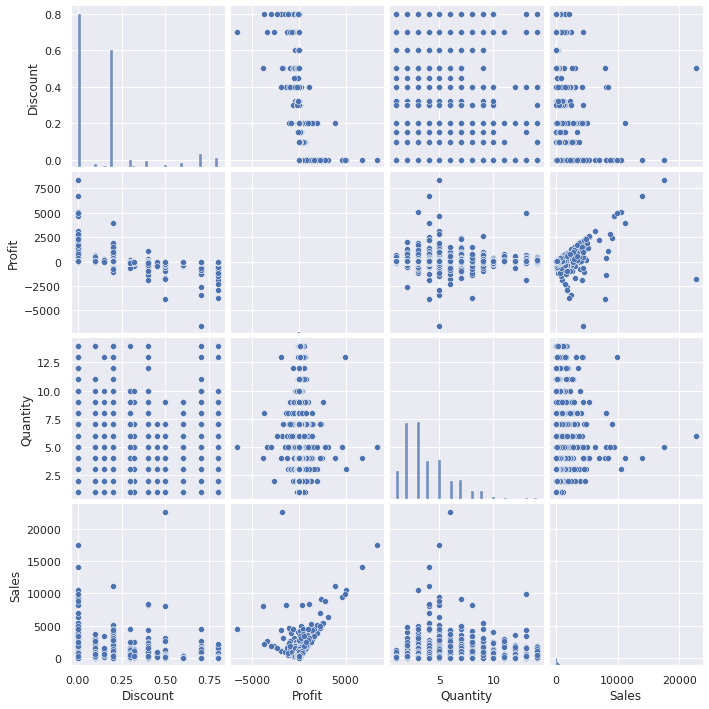

In [10]:
sns.pairplot(cars_df);

But there are numerous variables and numerous more relationships between these variables. We can do better through PCA.

##  Visualization by using PCA

### Standardizing Variables
Standardization is a necessary  step in PCA formulation

In [13]:
cars_df

,Category,City,Country,Customer ID,Customer Name,Discount,Order Date,Order ID,Product ID,Product Name,Profit,Quantity,Region,Sales,Segment,Ship Date,Ship Mode,State,Sub-Category
0,Furniture,Henderson,United States,CG-12520,Claire Gute,0.00,11/8/2016,CA-2016-152156,FUR-BO-10001798,Bush Somerset Collection Bookcase,41.9136,2,South,261.9600,Consumer,11/11/2016,Second Class,Kentucky,Bookcases
1,Furniture,Henderson,United States,CG-12520,Claire Gute,0.00,11/8/2016,CA-2016-152156,FUR-CH-10000454,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",219.5820,3,South,731.9400,Consumer,11/11/2016,Second Class,Kentucky,Chairs
2,Office Supplies,Los Angeles,United States,DV-13045,Darrin Van Huff,0.00,6/12/2016,CA-2016-138688,OFF-LA-10000240,Self-Adhesive Address Labels for Typewriters b...,6.8714,2,West,14.6200,Corporate,6/16/2016,Second Class,California,Labels
3,Furniture,Fort Lauderdale,United States,SO-20335,Sean O'Donnell,0.45,10/11/2015,US-2015-108966,FUR-TA-10000577,Bretford CR4500 Series Slim Rectangular Table,-383.0310,5,South,957.5775,Consumer,10/18/2015,Standard Class,Florida,Tables
4,Office Supplies,Fort Lauderdale,United States,SO-20335,Sean O'Donnell,0.20,10/11/2015,US-2015-108966,OFF-ST-10000760,Eldon Fold 'N Roll Cart System,2.5164,2,South,22.3680,Consumer,10/18/2015,Standard Class,Florida,Storage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,Furniture,Miami,United States,TB-21400,Tom Boeckenhauer,0.20,1/21/2014,CA-2014-110422,FUR-FU-10001889,Ultra Door Pull Handle,4.1028,3,South,25.2480,Consumer,1/23/2014,Second Class,Florida,Furnishings
9990,Furniture,Costa Mesa,United States,DB-13060,Dave Brooks,0.00,2/26/2017,CA-2017-121258,FUR-FU-10000747,Tenex B1-RE Series Chair Mats for Low Pile Car...,15.6332,2,West,91.9600,Consumer,3/3/2017,Standard Class,California,Furnishings
9991,Technology,Costa Mesa,United States,DB-13060,Dave Brooks,0.20,2/26/2017,CA-2017-121258,TEC-PH-10003645,Aastra 57i VoIP phone,19.3932,2,West,258.5760,Consumer,3/3/2017,Standard Class,California,Phones
9992,Office Supplies,Costa Mesa,United States,DB-13060,Dave Brooks,0.00,2/26/2017,CA-2017-121258,OFF-PA-10004041,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",13.3200,4,West,29.6000,Consumer,3/3/2017,Standard Class,California,Paper


In [18]:
# separating the quantitative predictors from the model of the car (a string)
#model = cars_df['model']
#quant_df = cars_df[cars_df.columns.difference(['model'])]
quant_df=cars_df[['Sales','Profit','Discount','Quantity']]
# Standardization
quant_scaled = StandardScaler().fit_transform(quant_df)
cars_df_scaled = pd.DataFrame(quant_scaled, columns=quant_df.columns)

# We can bring back the model variable, although we do not need it
#cars_df_scaled['model'] = cars_df['model']
cars_df_scaled.head()


,Sales,Profit,Discount,Quantity
0,0.051510,0.056593,-0.756643,-0.804303
1,0.805633,0.815054,-0.756643,-0.354865
2,-0.345368,-0.093002,-0.756643,-0.804303
3,1.167688,-1.757484,1.423149,0.544012
4,-0.332935,-0.111593,0.212153,-0.804303


In [19]:
cars_df_scaled.describe()

,Sales,Profit,Discount,Quantity
count,9.994000e+03,9.994000e+03,9.994000e+03,9.994000e+03
mean,-6.115169e-17,-1.192818e-17,-8.089498e-16,-6.016578e-17
std,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00
min,-3.681144e-01,-2.829746e+01,-7.566435e-01,-1.253742e+00
25%,-3.410996e-01,-1.149555e-01,-7.566435e-01,-8.043034e-01
50%,-2.813929e-01,-8.533846e-02,2.121533e-01,-3.548649e-01
75%,-3.196013e-02,3.018606e-03,2.121533e-01,5.440122e-01
max,3.595655e+01,3.573693e+01,3.118544e+00,4.588959e+00


### Carrying out PCA

[Sklearn PCA documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

In [20]:
# drop again the model predictor
quant_df = cars_df_scaled #cars_df_scaled[cars_df_scaled.columns.difference(['model'])]

# fitting the PCA object onto our dataframe (excluding the model name column)
pca = PCA().fit(quant_df)

# transforming the dataframe
quant_df_pca = pca.transform(quant_df)

print('Original dimensions:', quant_df.shape)
print('PCA dimensions:     ', quant_df_pca.shape)

Original dimensions: (9994, 4)
PCA dimensions:      (9994, 4)


Let us examine some of the attributes we obtain from PCA.

1. `explained_variance_`: The amount of variance explained by each of the selected principal components.
2. `explained_variance_ratio_`: Percentage of variance explained by each of the selected principal components. By default, unless `n_components` is  specified  all components will be stored and the sum of the ratios will be  1.0.

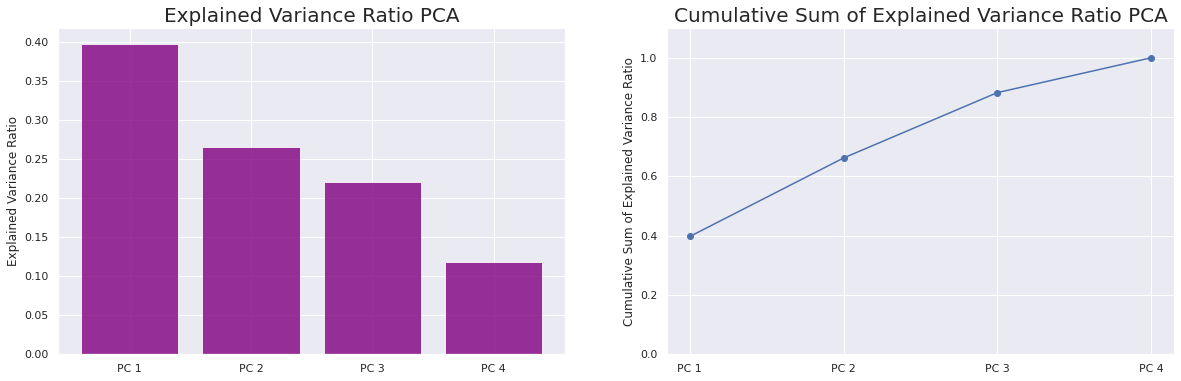

In [21]:
fig, ax = plt.subplots(ncols=2, figsize=(20,6))
ax1, ax2 = ax.ravel()

ratio = pca.explained_variance_ratio_
ax1.bar(range(len(ratio)), ratio, color='purple', alpha=0.8)
ax1.set_title('Explained Variance Ratio PCA', fontsize=20)
ax1.set_xticks(range(len(ratio)))
ax1.set_xticklabels(['PC {}'.format(i+1) for i in range(len(ratio))])
ax1.set_ylabel('Explained Variance Ratio')

# ratio[0]=0
ratio = pca.explained_variance_ratio_
ax2.plot(np.cumsum(ratio), 'o-')

ax2.set_title('Cumulative Sum of Explained Variance Ratio PCA', fontsize=20)

ax2.set_ylim(0,1.1)
ax2.set_xticks(range(len(ratio)))
ax2.set_xticklabels(['PC {}'.format(i+1) for i in range(len(ratio))])
ax2.set_ylabel('Cumulative Sum of Explained Variance Ratio');

We see that over 85% of the variance is explained by the first 2 principal components! 

3. `components_`: This represents the principal components i.e. directions of maximum variance in the data. The components are sorted by `explained_variance_`. 

Let us write the equation for all the principal components using our formulation of the principal components above:

$$
Z_i = \sum_{j=1}^{p} w_{ij} X_i
$$

In [22]:
for i, comp in enumerate(pca.components_):
    expression = 'Z_{} = '.format(i+1)
    for c, x in zip(comp, quant_df.columns):
        if c < 0:
            expression += str(np.round(c,2)) + '*' + x + ' '
        else:
            expression += '+' + str(np.round(c,2)) + '*' + x + ' '
    print(expression + '\n')

Z_1 = +0.64*Sales +0.66*Profit -0.27*Discount +0.29*Quantity 

Z_2 = +0.22*Sales -0.2*Profit +0.72*Discount +0.63*Quantity 

Z_3 = +0.31*Sales +0.25*Profit +0.59*Discount -0.7*Quantity 

Z_4 = +0.67*Sales -0.68*Profit -0.25*Discount -0.16*Quantity 



Using the printed equations above, we can create vectors showing where each feature has a high value. Let us do this for the **first 2 principal components** (using $v$ to denote a vector): 

$$
\begin{aligned}
v_{carb} = \begin{pmatrix}-0.24 \\ 0.48 \end{pmatrix}, \;
v_{cyl} = \begin{pmatrix}-0.4 \\ 0.02 \end{pmatrix}, \; 
v_{disp} = \begin{pmatrix}-0.4 \\ -0.09 \end{pmatrix}, \\
v_{drat} = \begin{pmatrix}0.31 \\ 0.34 \end{pmatrix}, \;
v_{gear} = \begin{pmatrix}0.21 \\ 0.55 \end{pmatrix}, \;
v_{hp} = \begin{pmatrix}-0.37 \\ 0.27 \end{pmatrix}, \\
v_{mpg} = \begin{pmatrix}0.39 \\ 0.03 \end{pmatrix}, \;
v_{qsec} = \begin{pmatrix}0.22 \\ -0.48 \end{pmatrix}, \;
v_{wt} = \begin{pmatrix}-0.37 \\ -0.17 \end{pmatrix}
\end{aligned}
$$

### Checking if our vectors are orthonormal
Orthonormal vectors are the vectors which are orthogonal (zero dot product) with length equal to one (unit vectors).

#### Orthogonal:
We use the dot product between two vectors to check if the vectors are orthogonal or not. If the dot product is 0, that means that the two vectors are orthogonal. The dot product between two vectors is (geometrically): 

$$
\textbf{a} \cdot \textbf{b} = ||\textbf{a}|| ||\textbf{b}|| \cos(\theta)
$$

Where $\theta$ is the angle between the two vectors and $||\cdot||$ denotes the norm of the vector. Since we assume that the norm of a vector is non-zero, the only way the dot product of two vectors to be zero is when the angle between them is 90 degrees ($\cos(90) = 0$). Thus, the dot product is a way to check if two vectors are perpendicular.

#### Unit vectors
In order to calculate the length $||\textbf{a}||$ of a vector we can take the dot product of a vector with itself, namely
$$ 
||\textbf{a}|| =  \textbf{a}\cdot \textbf{a}
$$

In [23]:
vec1 = pca.components_[0]
vec2 = pca.components_[1]

# print(np.dot(vec1.T, vec2))
print('The dot product between the first two principal components is ',np.round(np.dot(vec1, vec2),5))
print('The length of the first  principal component is ',np.round(np.dot(vec1, vec1),5))

The dot product between the first two principal components is  0.0
The length of the first  principal component is  1.0


We see that the first two principal components are orthogonal and the first principal component is also a unit vector. You can check other pairs of principal components in order to convince yourself that all principal components are always pairwise orthogonal unit vectors.

### Visualizing PCA results

KeyError: ignored

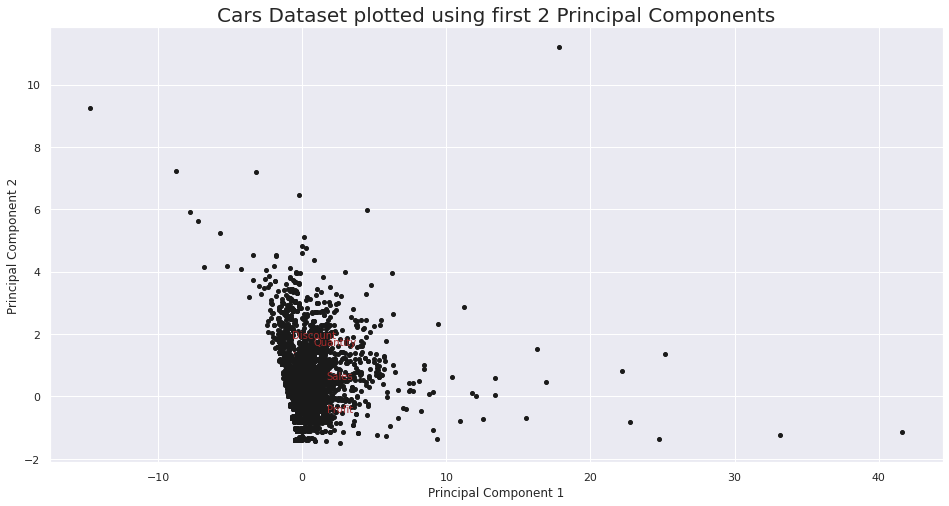

In [24]:
# to plot vectors from the center
vecs = pca.components_[0:10].T *2

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(quant_df_pca[:,0], quant_df_pca[:,1], 'ok', markersize=4)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('Cars Dataset plotted using first 2 Principal Components', fontsize=20)

# plotting arrowheads of the original axes projected on the 2D PCA space
for i, vec in enumerate(vecs):
    ax.arrow(0,0,vec[0],vec[1], color='brown', head_width=0.1)
    s = 1.3
    ax.annotate(quant_df.columns[i], (s*vec[0], s*vec[1]), color='brown')

# annotating text
for i, txt in enumerate(cars_df_scaled['model']):
    ax.annotate(txt, (quant_df_pca[:,0][i], quant_df_pca[:,1][i]), size=12)

**Any patterns of interest?** Let us examine the geography more closely. Source: [this blog](https://www.datacamp.com/community/tutorials/pca-analysis-r). 

In [ ]:
country = ["Japan", "US", "EU", "US", "EU", "Japan", "US", "EU", "US", "EU"]
times = [3, 4, 7, 3, 1, 3, 4, 3, 1, 3]
country_list = np.array(sum(([x]*y for x,y in zip(country, times)),[]))

In [ ]:
len(country_list)

32

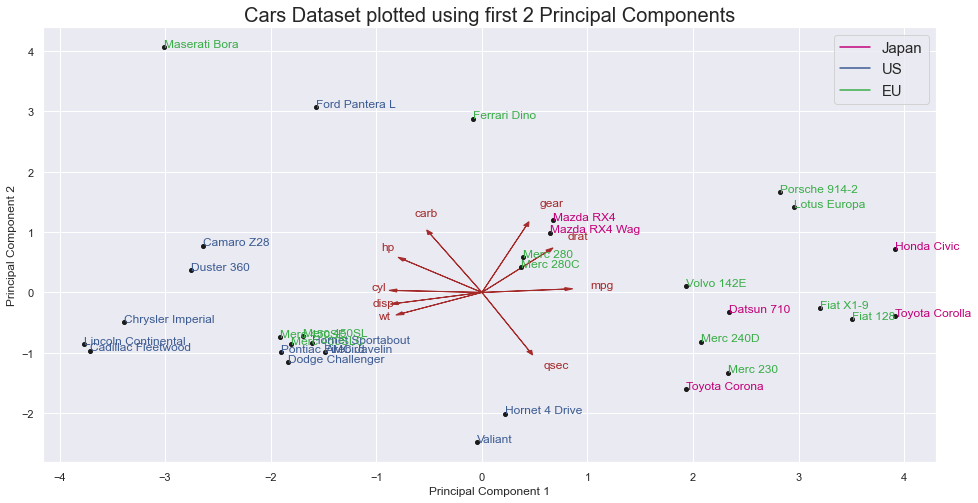

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

# main plot
ax.plot(quant_df_pca[:,0], quant_df_pca[:,1], 'ok', markersize=4)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('Cars Dataset plotted using first 2 Principal Components', fontsize=20)

# plotting arrowheads
for i, vec in enumerate(vecs):
    ax.arrow(0,0,vec[0],vec[1], color='brown', head_width=0.05)
    s = 1.3
    ax.annotate(quant_df.columns[i], (s*vec[0], s*vec[1]), color='brown')

# plotting names
cs = [sns.xkcd_rgb["magenta"], sns.xkcd_rgb["denim blue"], sns.xkcd_rgb["medium green"]]
colors = {"Japan": cs[0], "US": cs[1], "EU": cs[2]}

# dummy plots to show up in the legend
ax.plot(0,0, color=cs[0], label='Japan')
ax.plot(0,0, color=cs[1], label='US')
ax.plot(0,0, color=cs[2], label='EU')

# plotting text with color
for i, txt in enumerate(cars_df_scaled['model']):
    country = country_list[i]
    ax.annotate(txt, (quant_df_pca[:,0][i], quant_df_pca[:,1][i]), color=colors[country], size=12)
    
ax.legend(fontsize=15);

What patterns do you see now?

For example, looking at the axes, we  see that the American cars are characterized by high values for number of *cyl*, *disp*, and  *wt*. Thus they are more powerful and heavier cars. Japanese cars, on the other hand, are characterized by higher fuel efficieny (*mpg*). European cars are somewhat in the middle and less tightly clustered than either group, but are average more efficient than American cars

**We can draw conclusions visually. Not any modeling so far.**